In [ ]:
!pip install unidecode
!pip install contractions
!pip install wordninja
!pip install collections
!pip install spellchecker
!pip install pyspellchecker
!pip install symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=110d0255e87842944cb26da9ec0b087060168219ded455453dcca3398646944b
  Stored in directory: /root/.cache/pip/wheels/aa/44/3a/f2a5c1859b8b541ded969b4cd12d0a58897f12408f4f51e084
Successfully built wordninja
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 31.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setu

In [ ]:
import os
import pandas as pd
import numpy as np
import spacy
import unidecode
import contractions as contract
import re
import wordninja
import collections
import pkg_resources
from spellchecker import SpellChecker
from symspellpy import SymSpell, Verbosity

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Suicide_Detection/Suicide_Detection.csv', index_col=0)



1. Spell Check
2. Remove words from Stopwords
3. Remove Whitespaces
4. Remove accented characteres
5. Remove URL
6. Remove Symbols & Digits
7. Fix Lengthening (Remove extra characters)




In [ ]:
df.reset_index(drop=True, inplace=True)
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
# Defining methods
import spacy


nlp = spacy.load("en_core_web_sm")
vocab = collections.Counter()
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
"symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

True

In [ ]:
# Spell Check using Symspell
def fix_spelling(text):
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    correctedtext = suggestions[0].term # get the first suggestion, otherwise returns original text if nothing is corrected
    return correctedtext

In [ ]:
# Remove some important words from stopwords list
deselect_stop_words = ["not", "no", "never", "always", "none", "nothing",
"nor", "cannot", "without", "against", "unless", "but", "however", "although",
"though", "yet", "perhaps", "maybe", "sometimes", "often", "always", "never"]

for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False

In [ ]:
# Remove extra whitespaces from text
def remove_whitespace(text):
    text = text.strip()
    return " ".join(text.split())

In [ ]:
# Remove accented characters from text, e.g. café
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

In [ ]:
# Remove URL
def remove_url(text):
    return re.sub(r'http\S+', '', text)

In [ ]:
# Removing symbols and digits
def remove_symbols_digits(text):
    return re.sub('[^a-zA-Z\s]', ' ', text)

In [ ]:
# Removing special characters
def remove_special(text):
    return text.replace("\r", " ").replace("\n", " ").replace("    ", " ").replace('"', '')


In [ ]:
# Fix word lengthening (characters are wrongly repeated)
def fix_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

In [ ]:
def text_preprocessing(text, accented_chars=True, contractions=True, convert_num=True,
                       extra_whitespace=True, lemmatization=True, lowercase=True,
                       url=True, symbols_digits=True, special_chars=True,
                       stop_words=True, lengthening=True, spelling=True):
    """preprocess text with default option set to true for all steps"""
    if accented_chars == True: # remove accented characters
        text = remove_accented_chars(text)
    if contractions == True: # expand contractions
        text = contract.fix(text)
    if lowercase == True: # convert all characters to lowercase
        text = text.lower()
    if url == True: # remove URLs before removing symbols
        text = remove_url(text)
    if symbols_digits == True: # remove symbols and digits
        text = remove_symbols_digits(text)
    if special_chars == True: # remove special characters
        text = remove_special(text)
    if extra_whitespace == True: # remove extra whitespaces
        text = remove_whitespace(text)
    if lengthening == True: # fix word lengthening
        text = fix_lengthening(text)
    if spelling == True: # fix spelling
        text = fix_spelling(text)

    doc = nlp(text) # tokenise text

    clean_text = []

    # return text

    for token in doc:
        flag = True
        edit = token.text
        # remove stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM':
            flag = False
        # exclude number words
        if convert_num == True and token.pos_ == 'NUM' and flag == True:
            flag = False
        # convert tokens to base form
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # append tokens edited and not removed to list
        if edit != "" and flag == True:
            clean_text.append(edit)
    return " ".join(clean_text)

In [ ]:
# Test functions on a subset of 20 rows
df['cleaned_text'] = df['text'][:20].apply(lambda row: text_preprocessing(row))
df[:20]


,text,class,cleaned_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threaten suicide recently leave wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,weird not affect compliment come know girl but...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally never hear bad year swear fucking god ...
3,i need helpjust help me im crying so hard,suicide,need help help cry hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,lose hello adam struggle year afraid past year...
5,Honetly idkI dont know what im even doing here...,suicide,honestly d not know feel like nothing feel not...
6,[Trigger warning] Excuse for self inflicted bu...,suicide,trigger warn excuse self inflict burn know cri...
7,It ends tonight.I can’t do it anymore. \nI quit.,suicide,end tonight not anymore quit
8,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,want edgy make self conscious feel like not st...
9,My life is over at 20 years oldHello all. I am...,suicide,life year old hello year old bald male hairlin...


In [ ]:
# Apply preprocessing to all data
df['cleaned_text'] = df['text'].apply(lambda row: text_preprocessing(row))

In [ ]:
# Export cleaned dataset
df.to_csv('/content/gdrive/MyDrive/Suicide_Detection/suicide_detection_full_cleaned.csv', index=False)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving suicide_detection_full_cleaned.csv to suicide_detection_full_cleaned.csv


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
import seaborn as sns

In [22]:
df = pd.read_csv('suicide_detection_full_cleaned.csv')
df.head()

,text,class,cleaned_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threaten suicide recently leave wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,weird not affect compliment come know girl but...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally never hear bad year swear fucking god ...
3,i need helpjust help me im crying so hard,suicide,need help help cry hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,lose hello adam struggle year afraid past year...


In [23]:
tokenizer = Tokenizer()
# Convert all entries to strings to avoid AttributeError
df['cleaned_text'] = df['cleaned_text'].astype(str)
tokenizer.fit_on_texts(df['cleaned_text'])
word_freq = pd.DataFrame(tokenizer.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)


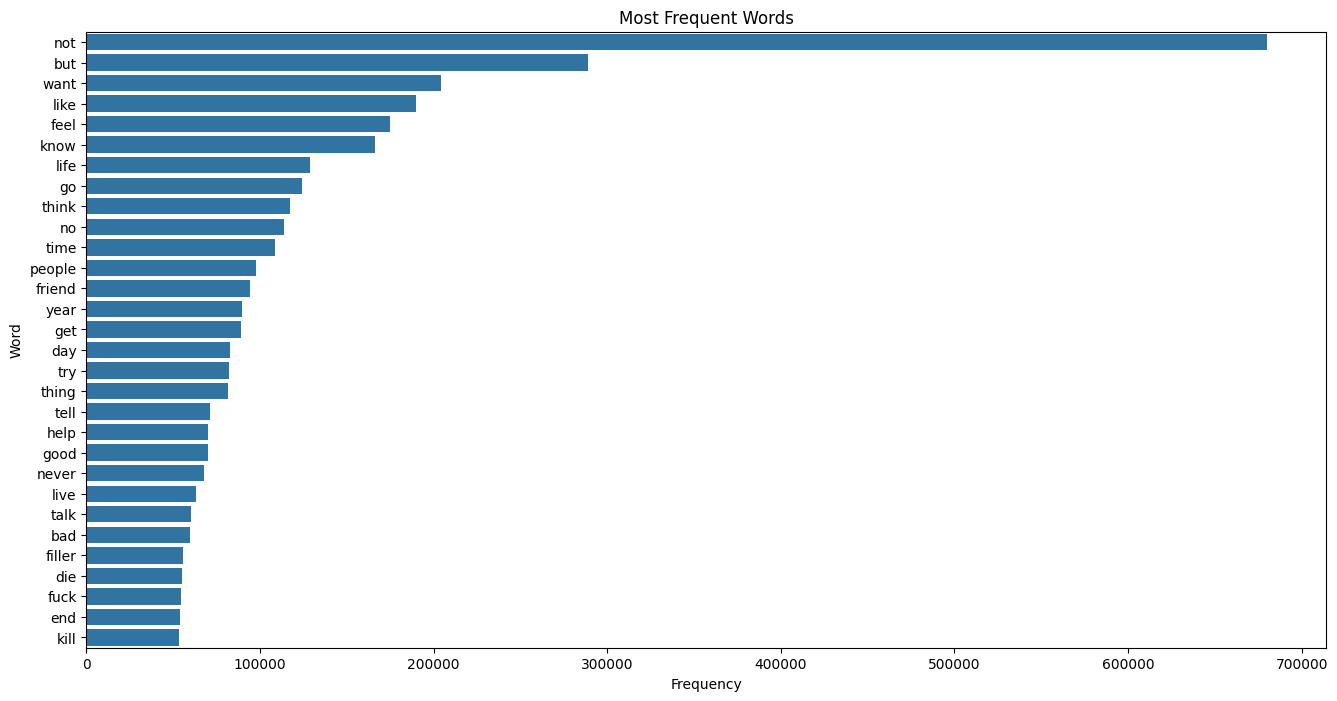

In [24]:
# Plot bar graph for word frequency
plt.figure(figsize=(16, 8))
sns.barplot(x='count',y='word',data=word_freq.iloc[:30])
plt.title('Most Frequent Words')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

In [25]:
#get rid of filler words in the english dict like umm, ughh like etc.
df['cleaned_text'] = df['cleaned_text'].str.replace('filler', '')

In [26]:
# Remove empty rows
df = df[df['cleaned_text'].apply(lambda x: len(x.split())!=0)]
df.reset_index(drop=True, inplace=True)
df.head()


,text,class,cleaned_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threaten suicide recently leave wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,weird not affect compliment come know girl but...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally never hear bad year swear fucking god ...
3,i need helpjust help me im crying so hard,suicide,need help help cry hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,lose hello adam struggle year afraid past year...


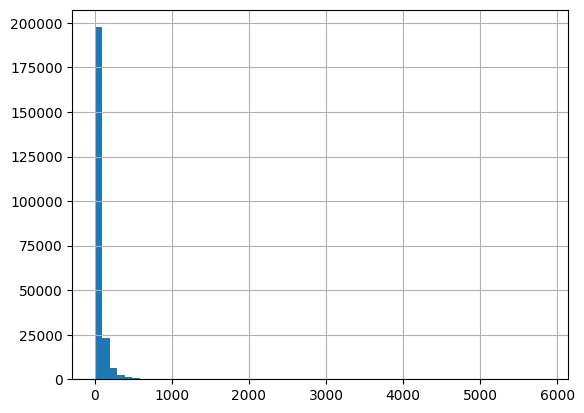

count    232066.000000
mean         54.002706
std          88.890163
min           1.000000
25%          11.000000
50%          25.000000
75%          63.000000
max        5850.000000
dtype: float64


In [27]:
# Get word count of posts
posts_len = [len(x.split()) for x in df['cleaned_text']]
pd.Series(posts_len).hist(bins=60)
plt.show()
print(pd.Series(posts_len).describe())

In [30]:
#convert rows to a length of 63, selecting the top 75% of the words
df = df[df['cleaned_text'].apply(lambda x: len(x.split())<=63)]
df.reset_index(drop=True, inplace=True)


In [32]:
#saving this final preprocessed and clean df
df.head()
df.to_csv('reddit_suicide_detection_final_clean.csv', index=False)